# Quantitative Risk Management — Assignment  
**Group Members:**  


**University of St. Gallen**  
**Autumn Semester 2025**

---



In [59]:
# Libraries
import pandas as pd
import numpy as np
from scipy import stats, optimize
from scipy.stats import norm, t
from scipy.special import gamma
import matplotlib.pyplot as plt


# Important! Change these to your own data paths.
path_credit = "qrm25HSG_creditportfolio.xlsx"
path_idx = "qrm25HSG_indexes.xlsx"

# 1. Data Preparation

We begin by importing the daily equity index data and computing weekly $\newline$
log-returns for the SPI and SPX indices. These will serve as the $\newline$
two-dimensional systematic risk factor:

$\Theta_t = (\text{SPI return},\ \text{SPX return}).$


In [60]:
idx_raw = pd.read_excel(path_idx)

prices = (
    pd.DataFrame({
        "Date": idx_raw["SPI Index"],
        "SPI": pd.to_numeric(idx_raw["Unnamed: 1"], errors="coerce"),
        "SPX": pd.to_numeric(idx_raw["Unnamed: 3"], errors="coerce"),
    })
    .dropna()
    .set_index("Date")
)

# ---------------------------------------------------------
# Get the logret_weekly array
# ---------------------------------------------------------

logret_daily = np.log(prices / prices.shift(1)).dropna()
logret_weekly = logret_daily.resample("W-FRI").sum().dropna()
theta_hist = logret_weekly.values     # shape (T, 2)
T = theta_hist.shape[0]

# 2. Parameter Extraction

In this section we load the **credit portfolio** and extract, for each counterparty 
$k = 1, \dots, 100$, the parameters needed for the latent-variable credit model:

- $E_k$: exposure in USD  
- $R_k$: recovery rate in case of default  
- $\pi_k$: unconditional probability of default  
- $a_k = (a_{k1}, a_{k2})'$: loading on the common risk factors (SPI, SPX)  
- $\lambda_k \in (0,1)$: weight of systematic risk in the asset-value process  

In [64]:
# Read file
credit = pd.read_excel(path_credit)

# Extract numpy arrays
E = credit["Exposure USD"].values         # exposures E_k
R = credit["R_k"].values                  # recovery rates R_k
pi = credit["pi_k"].values                # unconditional PDs π_k
a = credit[["a_k1", "a_k2"]].values       # factor loadings a_k (K x 2)
lam = credit["lambda_k"].values           # λ_k

# 3. Deriving $s_k$: Idiosyncratic Standard Deviation

The asset-value latent variable is:

$Y_k = \sqrt{\lambda_k} \, a_k' \Theta + \sqrt{1-\lambda_k} \, s_k \varepsilon_k$

Given:
$\text{Var}(Y_k) = s_k^2$
and the model structure:
$s_k^2 = a_k^\top \Sigma_\Theta a_k$

where $\Sigma_\Theta$ is the empirical covariance of the two index returns.

This section computes:
- empirical $\Sigma_\Theta$
- the corresponding vector $s_k$

In [72]:
# ---------------------------------------------------------
# Compute s_k and d_k for all k
# ---------------------------------------------------------
Sigma_emp = np.cov(theta_hist.T, bias=True)        # empirical Cov(Θ)

a = credit[["a_k1", "a_k2"]].values                # shape (K,2)
s2_k = np.einsum("ki,ij,kj->k", a, Sigma_emp, a)   # a_k' Σ a_k
s_k = np.sqrt(s2_k)

credit["s_k"] = s_k
credit["d_k"] = credit["s_k"] * stats.norm.ppf(credit["pi_k"])

print("\nFirst 5 counterparties with s_k and d_k:")
display(credit[["Exposure USD", "pi_k", "a_k1", "a_k2", "lambda_k", "s_k", "d_k"]].head())


First 5 counterparties with s_k and d_k:


,Exposure USD,pi_k,a_k1,a_k2,lambda_k,s_k,d_k
0,97944.764948,0.0002,0.440910,0.387963,0.399544,0.018212,-0.064472
1,70709.443541,0.0002,0.518740,0.752544,0.533480,0.028249,-0.100005
2,58577.716051,0.0002,0.431905,0.948270,0.941780,0.031126,-0.110187
3,12882.032958,0.0002,0.712869,0.299049,0.175186,0.022240,-0.078730
4,35578.381705,0.0002,0.630420,0.562591,0.172327,0.026218,-0.092813


# 4. Dependence Model Estimation (Points iv–vi)

We estimate three different models for $\Theta_t$:

### **Model M1 — Empirical Distribution**
Sampling with replacement from the historical $\theta_{\text{hist}}$

### **Model M2 — Gaussian Model**
Estimate:

$\mu,\ \Sigma$
using Gaussian MLE.

### **Model M3 — Gaussian Marginals + t-Copula**
- Fit Gaussian marginals  
- Convert residuals to uniforms  
- Estimate $ (\nu, \rho)$ via t-copula maximum likelihood  
- Construct the meta-distribution:  

$\Theta = \mu + \sigma \cdot \Phi^{-1}(U)$

This part computes:
- Marginal parameters $(\mu, \sigma)$
- Copula parameters $(\nu, \rho)$
- Diagnostic output

In [67]:
# ---------------------------------------------------------
# (iv) M2: Gaussian model
# ---------------------------------------------------------
mu_M2 = theta_hist.mean(axis=0)                 # shape (2,)
Sigma_M2 = np.cov(theta_hist.T, bias=True)      # shape (2,2)

print("M2 (Gaussian) estimates")
print("mu_M2 =", mu_M2)
print("Sigma_M2 =\n", Sigma_M2)



M2 (Gaussian) estimates
mu_M2 = [0.00129291 0.00196092]
Sigma_M2 =
 [[0.00052562 0.0004085 ]
 [0.0004085  0.00059622]]


In [68]:
# ---------------------------------------------------------
# (iv) M3: Gaussian marginals + t-copula
# ---------------------------------------------------------

# Step 1: estimate Gaussian marginals (mean & variance) for each component
mu_M3 = theta_hist.mean(axis=0)                        # (2,)
sigma2_M3 = ((theta_hist - mu_M3)**2).mean(axis=0)     # use divisor n
sigma_M3 = np.sqrt(sigma2_M3)

print("\nM3 (Normal marginals) estimates")
print("mu_M3 =", mu_M3)
print("sigma_M3 =", sigma_M3)


# Step 2: transform to uniforms via Normal CDF
z1 = (theta_hist[:, 0] - mu_M3[0]) / sigma_M3[0]
z2 = (theta_hist[:, 1] - mu_M3[1]) / sigma_M3[1]
U1_hat = stats.norm.cdf(z1)
U2_hat = stats.norm.cdf(z2)


# Numerical safety
eps = 1e-10
U1_hat = np.clip(U1_hat, eps, 1 - eps)
U2_hat = np.clip(U2_hat, eps, 1 - eps)

# Step 3: t-copula MLE for (nu, rho)

def ft1(x, nu):
    """
    Univariate t-density with df = nu.
    """
    c = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma(nu / 2))
    return c * (1 + x**2 / nu) ** (-(nu + 1) / 2)


def ft2(x1, x2, nu, rho):
    """
    Bivariate t-density with correlation rho and df = nu.
    """
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    const = gamma((nu + 2) / 2) / (gamma(nu / 2) * np.pi * nu * np.sqrt(1 - rho**2))
    Q = (x1**2 - 2 * rho * x1 * x2 + x2**2) / (nu * (1 - rho**2))
    return const * (1 + Q) ** (-(nu + 2) / 2)


def neg_loglik_tcopula(params, u1, u2):
    """
    Negative log-likelihood of the t-copula, given uniforms u1, u2.
    params = (nu, rho).
    """
    nu, rho = params

    # Parameter constraints
    if nu <= 0 or abs(rho) >= 1:
        return np.inf

    # t-quantiles
    t1 = t.ppf(u1, df=nu)
    t2 = t.ppf(u2, df=nu)

    # Bivariate and univariate t-densities
    ft2_vals = ft2(t1, t2, nu, rho)
    ft1_t1 = t.pdf(t1, df=nu)  # SciPy's univariate t pdf
    ft1_t2 = t.pdf(t2, df=nu)

    # Copula density
    c_vals = ft2_vals / (ft1_t1 * ft1_t2)

    # Guard against numerical problems
    if np.any(c_vals <= 0) or np.any(~np.isfinite(c_vals)):
        return np.inf

    logc = np.log(c_vals)
    return -np.sum(logc)  # negative log-likelihood


# Initial guess and bounds (nu > 2, |rho| < 1)
init_params = np.array([5.0, 0.7])
bounds = [(2.01, 50.0), (-0.99, 0.99)]

res_M3 = optimize.minimize(
    neg_loglik_tcopula,
    init_params,
    args=(U1_hat, U2_hat),
    method="L-BFGS-B",
    bounds=bounds,
)

if not res_M3.success:
    print("M3 optimization did not converge:", res_M3.message)

nu_M3, rho_M3 = res_M3.x
loglik_copula_M3 = -res_M3.fun

print("\nT-copula parameter estimates (M3):")
print(f"nu_M3  = {nu_M3:.6f}")
print(f"rho_M3 = {rho_M3:.6f}")
print(f"Copula log-likelihood = {loglik_copula_M3:.3f}")



M3 (Normal marginals) estimates
mu_M3 = [0.00129291 0.00196092]
sigma_M3 = [0.02292632 0.02441767]

T-copula parameter estimates (M3):
nu_M3  = 5.796018
rho_M3 = 0.785982
Copula log-likelihood = 480.465


# 5. Simulation of Variables $Y_k$ (Point vii)

For each model (M1, M2, M3), and for each counterparty $k$, we simulate:

$Y_k^{(i)} = \sqrt{\lambda_k} a_k' \Theta^{(i)} + 
\sqrt{1 - \lambda_k}\, s_k \varepsilon_k^{(i)}$

This section runs:
- $N_{\text{sim}}$ simulations of $\Theta$
- transformation into $Y_k$
- verification examples

In [69]:
# ---------------------------------------------------------
# Helper: simulate Theta under each model
# ---------------------------------------------------------

def simulate_theta_M1(n_sims, theta_hist, rng):
    """
    M1: empirical distribution → sample with replacement from historical θ_t.
    """
    idx = rng.integers(0, len(theta_hist), size=n_sims)
    return theta_hist[idx, :]   # shape (n_sims, 2)


def simulate_theta_M2(n_sims, mu, Sigma, rng):
    """
    M2: bivariate Gaussian N(mu, Sigma).
    """
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=n_sims)


def simulate_theta_M3(n_sims, mu, sigma, nu, rho, rng):
    """
    M3: Gaussian marginals with a t-copula.
      1. simulate bivariate standard t with corr rho, df nu
      2. map to uniforms via t-CDF
      3. map to normals via Φ^{-1}
      4. scale/shift to Gaussian marginals N(mu_i, sigma_i^2)
    """
    # Step 1: simulate bivariate standard t with corr rho
    #   Z ~ N(0, R), W ~ Chi-square(nu)
    R = np.array([[1.0, rho],
                  [rho, 1.0]])
    Z = rng.multivariate_normal(mean=[0.0, 0.0], cov=R, size=n_sims)
    W = rng.chisquare(df=nu, size=n_sims)
    T_vals = Z / np.sqrt(W / nu)[:, None]   # (n_sims, 2)

    # Step 2: uniforms via t CDF
    U = stats.t.cdf(T_vals, df=nu)

    # Numerical safety
    eps = 1e-10
    U = np.clip(U, eps, 1 - eps)

    # Step 3: normals via inverse Φ
    Z_norm = stats.norm.ppf(U)   # (n_sims, 2)

    # Step 4: scale/shift to N(mu_i, sigma_i^2)
    Theta = mu[None, :] + sigma[None, :] * Z_norm
    return Theta   # shape (n_sims, 2)


# ---------------------------------------------------------
# Helper: simulate Y_k given Θ-simulations
# ---------------------------------------------------------

lam = credit["lambda_k"].values              # (K,)
a = credit[["a_k1", "a_k2"]].values          # (K,2)  (re-used from above)
s_k = credit["s_k"].values                   # (K,)
K = len(credit)

def simulate_Y(theta_sims, rng):
    """
    theta_sims: (n_sims, 2)
    Returns: Y matrix of shape (n_sims, K).
    """
    n_sims = theta_sims.shape[0]

    # systematic part: sqrt(λ_k) * a_k' Θ
    systematic_base = theta_sims @ a.T           # (n_sims, K)
    sqrt_lambda = np.sqrt(lam)[None, :]         # (1,K) broadcast
    systematic = sqrt_lambda * systematic_base  # (n_sims, K)

    # idiosyncratic part: sqrt(1-λ_k) * s_k * ε_k
    eps = rng.standard_normal(size=(n_sims, K))
    idio = np.sqrt(1 - lam)[None, :] * s_k[None, :] * eps

    Y = systematic + idio
    return Y

In [70]:
# ---------------------------------------------------------
# Run each simulation
# ---------------------------------------------------------
N_SIM = 10_000
rng = np.random.default_rng(123)  # keep this for replicability!

# ---------------------------------------------------------
# M1:
# ---------------------------------------------------------

theta_M1 = simulate_theta_M1(N_SIM, theta_hist, rng)
Y_M1 = simulate_Y(theta_M1, rng)   # shape (N_SIM, K)

print("\nM1: Y simulations shape =", Y_M1.shape)

# ---------------------------------------------------------
# M2:
# ---------------------------------------------------------

theta_M2 = simulate_theta_M2(N_SIM, mu_M2, Sigma_M2, rng)
Y_M2 = simulate_Y(theta_M2, rng)

print("\nM2: Y simulations shape =", Y_M2.shape)
print("Example: first scenario Y_M2[0, :5] =", Y_M2[0, :5])

# ---------------------------------------------------------
# M3:
# ---------------------------------------------------------

theta_M3 = simulate_theta_M3(N_SIM, mu_M3, sigma_M3, nu_M3, rho_M3, rng)
Y_M3 = simulate_Y(theta_M3, rng)

print("\nM3: Y simulations shape =", Y_M3.shape)
print("Example: first scenario Y_M3[0, :5] =", Y_M3[0, :5])


M1: Y simulations shape = (10000, 100)

M2: Y simulations shape = (10000, 100)
Example: first scenario Y_M2[0, :5] = [ 0.0128842  -0.01097461 -0.01832065 -0.03148574 -0.00210962]

M3: Y simulations shape = (10000, 100)
Example: first scenario Y_M3[0, :5] = [-0.01988521  0.00655323 -0.04496402  0.03529005 -0.00422253]


# 6. Portfolio Loss Distribution (Point vii)


In [71]:
# zhuohan code, returns a loss vector
# place holder:

L_M1 = np.random.normal(loc=0.0, scale=1e6, size=N_SIM)
L_M2 = np.random.normal(loc=0.0, scale=1e6, size=N_SIM)
L_M3 = np.random.normal(loc=0.0, scale=1e6, size=N_SIM)

# 7. Risk Measures: VaR & ES (Point viii)

We compute empirical:

$\text{VaR}_\alpha(L), \quad \text{ES}_\alpha(L)$
for:
- $\alpha = 95\%, 99\%, 99.9\%$
- each model (M1, M2, M3)

This section includes:
- numerical computation  
- comparison tables  
- bar-chart visualizations  
- distribution overlays  

In [73]:
# ---------------------------------------------------------
# Risk measure helpers: VaR and ES for loss distributions
# ---------------------------------------------------------

def var_empirical(losses, alpha=0.99):
    """
    Empirical VaR at level alpha for a vector of losses (positive = loss).
    """
    losses = np.asarray(losses)
    return np.quantile(losses, alpha)


def es_empirical(losses, alpha=0.99):
    """
    Empirical Expected Shortfall (ES) at level alpha:
    mean loss conditional on loss >= VaR_alpha.
    """
    losses = np.asarray(losses)
    v = var_empirical(losses, alpha)
    tail = losses[losses >= v]
    return tail.mean()

In [74]:
alphas = (0.95, 0.99, 0.999)
models = ["M1", "M2", "M3"]
loss_dict = {"M1": L_M1, "M2": L_M2, "M3": L_M3}

# Collect VaR and ES into a convenient structure
var_results = {alpha: {} for alpha in alphas}
es_results = {alpha: {} for alpha in alphas}

for alpha in alphas:
    for m in models:
        losses = loss_dict[m]
        var_results[alpha][m] = var_empirical(losses, alpha)
        es_results[alpha][m] = es_empirical(losses, alpha)

# pretty print as a small table
print("\n=== VaR (loss) ===")
for alpha in alphas:
    print(f"\nalpha = {alpha:.3f}")
    for m in models:
        print(f"  {m}: VaR = {var_results[alpha][m]:12.2f}")

print("\n=== ES (loss) ===")
for alpha in alphas:
    print(f"\nalpha = {alpha:.3f}")
    for m in models:
        print(f"  {m}: ES  = {es_results[alpha][m]:12.2f}")


=== VaR (loss) ===

alpha = 0.950
  M1: VaR =   1654366.36
  M2: VaR =   1653617.30
  M3: VaR =   1631053.79

alpha = 0.990
  M1: VaR =   2310603.97
  M2: VaR =   2370173.46
  M3: VaR =   2349687.25

alpha = 0.999
  M1: VaR =   3124276.48
  M2: VaR =   2959420.73
  M3: VaR =   3063240.42

=== ES (loss) ===

alpha = 0.950
  M1: ES  =   2055470.22
  M2: ES  =   2074872.49
  M3: ES  =   2056338.46

alpha = 0.990
  M1: ES  =   2633582.67
  M2: ES  =   2675153.14
  M3: ES  =   2640997.02

alpha = 0.999
  M1: ES  =   3269455.69
  M2: ES  =   3369886.27
  M3: ES  =   3250674.08


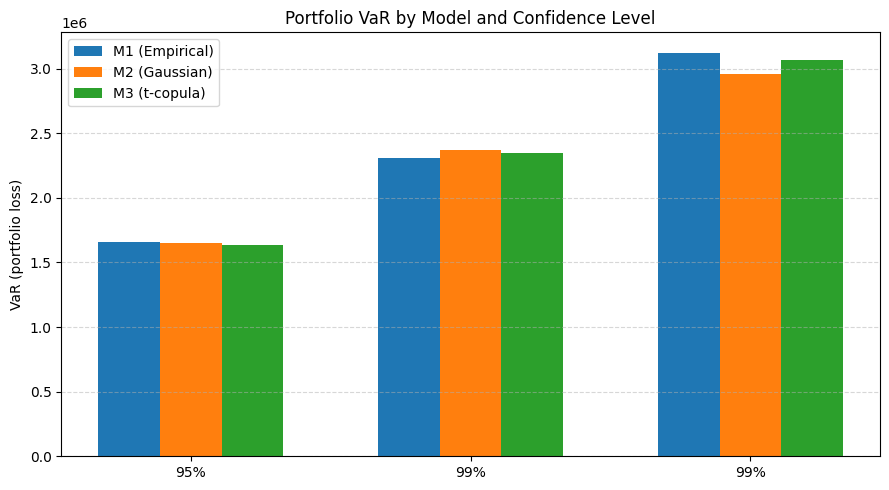

In [75]:
# ---------------------------------------------------------
# VaR bar chart by model and confidence level
# ---------------------------------------------------------

alpha_labels = [f"{int(a*100)}%" for a in alphas]
x = np.arange(len(alpha_labels))  # positions for each alpha on x-axis
width = 0.22                      # bar width

fig, ax = plt.subplots(figsize=(9, 5))

# Extract VaR in consistent order
var_M1 = [var_results[a]["M1"] for a in alphas]
var_M2 = [var_results[a]["M2"] for a in alphas]
var_M3 = [var_results[a]["M3"] for a in alphas]

ax.bar(x - width,     var_M1, width, label="M1 (Empirical)")
ax.bar(x,             var_M2, width, label="M2 (Gaussian)")
ax.bar(x + width,     var_M3, width, label="M3 (t-copula)")

ax.set_xticks(x)
ax.set_xticklabels(alpha_labels)
ax.set_ylabel("VaR (portfolio loss)")
ax.set_title("Portfolio VaR by Model and Confidence Level")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

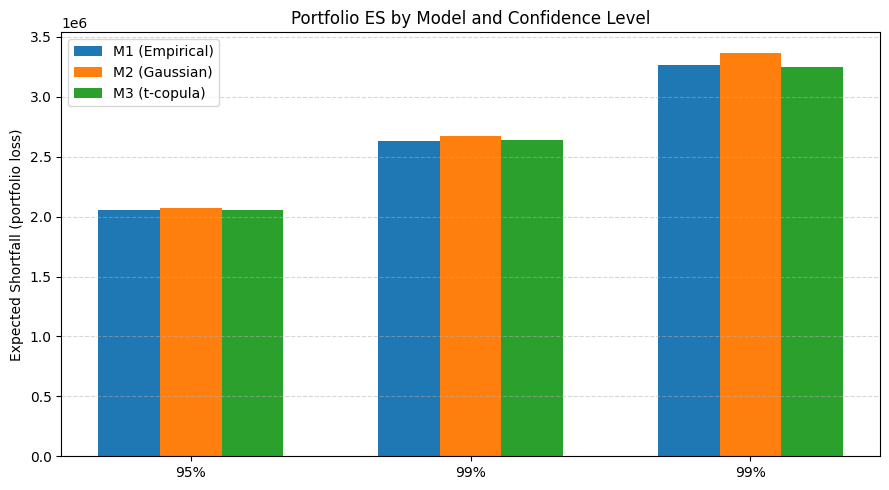

In [76]:
# ---------------------------------------------------------
# ES bar chart by model and confidence level
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 5))

es_M1 = [es_results[a]["M1"] for a in alphas]
es_M2 = [es_results[a]["M2"] for a in alphas]
es_M3 = [es_results[a]["M3"] for a in alphas]

ax.bar(x - width,     es_M1, width, label="M1 (Empirical)")
ax.bar(x,             es_M2, width, label="M2 (Gaussian)")
ax.bar(x + width,     es_M3, width, label="M3 (t-copula)")

ax.set_xticks(x)
ax.set_xticklabels(alpha_labels)
ax.set_ylabel("Expected Shortfall (portfolio loss)")
ax.set_title("Portfolio ES by Model and Confidence Level")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

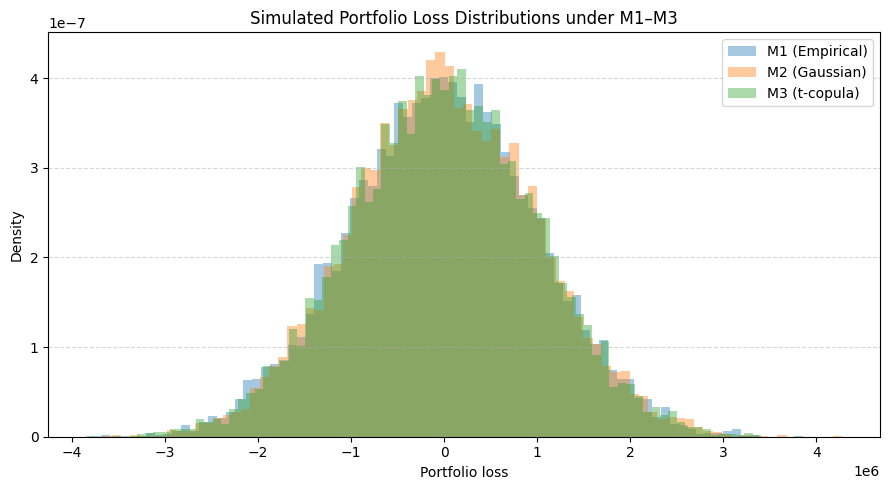

In [77]:
# ---------------------------------------------------------
# : overlay histograms of loss distributions
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 5))

ax.hist(L_M1, bins=80, density=True, alpha=0.4, label="M1 (Empirical)")
ax.hist(L_M2, bins=80, density=True, alpha=0.4, label="M2 (Gaussian)")
ax.hist(L_M3, bins=80, density=True, alpha=0.4, label="M3 (t-copula)")

ax.set_xlabel("Portfolio loss")
ax.set_ylabel("Density")
ax.set_title("Simulated Portfolio Loss Distributions under M1–M3")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# 8. Dynamic Risk Measures (Point ix)

We evaluate how VaR and ES evolve over time using a **rolling 500-day window** 
of daily SPI/SPX returns.
